In [2]:
import numpy as np
import pandas as pd
import json
# import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
# from sklearn.model_selection import RandomizedSearchCV
from create_embedding import creating_embedding_index, creating_embedding_matrix, get_id_word
from word_index import *
from attention import AttentionLayer
from preprocesing import *

%matplotlib inline

for module in [np, pd, tf, keras]:
    print(module.__name__, module.__version__)

numpy 1.16.2
pandas 0.18.1
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
reviews = GetReviews('./datasets_eg/seq2seq_data/reviews.csv').get_reviews()
reviews.shape

(568412, 2)

In [3]:
%%time
# clean text summary
reviews = get_cleaned_data(reviews)
# reviews.head()

Summaries are complete.
Texts are complete.
Wall time: 21min 18s


In [12]:
reviews.head()

,Summary,Text
0,good quality dog food,bought several vitality canned dog food produc...
1,advertised,product arrived labeled jumbo salted peanuts p...
2,delight says,confection around centuries light pillowy citr...
3,cough medicine,looking secret ingredient robitussin believe f...
4,great taffy,great taffy great price wide assortment yummy ...


In [13]:
%%time
# count all the word in data, get the vocab
words_counts = get_words_counts(reviews.Summary, reviews.Text)
len(words_counts)

Size of Vocabulary: 132737
Wall time: 44.8 s


132737

In [3]:
%%time
embedding_index = creating_embedding_index('./datasets_eg/word_embedding/numberbatch-en-17.04b.txt')
len(embedding_index)

Wall time: 2min 10s


418082

In [9]:
threshold = 20 # 设置word出现的阈值
show_missing_words(words_counts, embedding_index, threshold)

Number of words missing from CN: 3866
Percent of words that are missing from vocabulary: 2.91%


In [10]:
vocab_to_int, int_to_vocab = get_word_int_dic(words_counts, embedding_index, threshold)

Total number of unique words: 132737
Number of words we will use: 59461
Percent of words we will use: 44.800000000000004%


In [14]:
import json
word2id_json = json.dumps(vocab_to_int)
id2word_json = json.dumps(int_to_vocab)
with open("./datasets_eg/review_summary_word_id_json.txt", "w", encoding="utf8") as f:
    f.write(word2id_json)
with open("./datasets_eg/review_summary_id_word_json.txt",  "w", encoding="utf8") as f:
    f.write(id2word_json)

In [4]:
with open("./datasets_eg/review_summary_word_id_json.txt", "r", encoding="utf8") as f:
    word2id_json = f.read()
    vocab_to_int = json.loads(word2id_json)
with open("./datasets_eg/review_summary_id_word_json.txt", "r", encoding="utf8") as f:
    id2word_json = f.read()
    int_to_vocab = json.loads(id2word_json)

In [5]:
embedding_dim = 300
word_embedding_matrix = get_embedding_matrix(vocab_to_int, embedding_index, embedding_dim)
word_embedding_matrix[:5]

59461


array([[-0.20488881,  0.29177527, -0.78061992, ...,  0.66315726,
         0.96199672, -0.47154323],
       [-0.9817521 ,  0.31061837,  0.84452598, ..., -0.24681338,
        -0.60902696,  0.4447549 ],
       [ 0.47218088,  0.06721638,  0.55204674, ...,  0.67530326,
        -0.63301581, -0.57777402],
       [-0.20981508,  0.70842225, -0.57579842, ..., -0.01306362,
         0.33662391,  0.63391186],
       [ 0.0271    ,  0.1203    , -0.0418    , ..., -0.0197    ,
         0.0192    ,  0.0044    ]])

In [6]:
%%time
# convert the clean_summaries and clean_texts to int
int_summaries, word_count, unk_count = convert_to_ints(reviews.Summary, vocab_to_int, eos=True)
int_texts, word_count, unk_count = convert_to_ints(reviews.Text, vocab_to_int, word_count, 
                                                   unk_count)

NameError: name 'reviews' is not defined

In [17]:
int_summaries[:5]

[[52470, 28227, 46956, 33597, 2],
 [3089, 2],
 [53043, 6166, 2],
 [37174, 1660, 2],
 [9502, 31839, 2]]

In [18]:
length_of_summaries = create_lengths(int_summaries)
length_of_texts = create_lengths(int_texts)
print(length_of_summaries.describe())
print(length_of_texts.describe())

              counts
count  568412.000000
mean        3.911430
std         1.635204
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        26.000000
              counts
count  568412.000000
mean       40.996782
std        42.520854
min         0.000000
25%        17.000000
50%        28.000000
75%        49.000000
max      2084.000000


In [19]:
print(np.percentile(length_of_summaries.counts, 90))
print(np.percentile(length_of_texts.counts, 90))

6.0
83.0


In [20]:
%%time
summaries_maxlen = 5
texts_maxlen = 84
summaries_padded = keras.preprocessing.sequence.pad_sequences(int_summaries, value=vocab_to_int['<PAD>'], 
                                                              maxlen=summaries_maxlen,
                                                              padding="post", truncating="post")


texts_padded = keras.preprocessing.sequence.pad_sequences(int_texts, value=vocab_to_int['<PAD>'], 
                                                          maxlen=texts_maxlen,
                                                          padding="post", truncating="post")

Wall time: 36.4 s


In [7]:
np.savez("./datasets_eg/summary_text_padded.npz", summaries_padded=summaries_padded, texts_padded=texts_padded)

NameError: name 'summaries_padded' is not defined

In [6]:
padded_data = np.load("./datasets_eg/summary_text_padded.npz")
summaries_padded = padded_data["summaries_padded"]
texts_padded = padded_data["texts_padded"]

训练阶段输入   
- encoder_input   
- decoder_input   
- decoder_target   
其中decoder_target是decoder_input的shift一位（如图）   
<img src="https://img-blog.csdn.net/20171201092713541">

In [7]:
def get_dec_input(target_data, vocab_to_int):
    # 补充<GO>,并移除最后一个字符
    GO = np.zeros((len(target_data),1), dtype=np.int32) + vocab_to_int["<GO>"]
    dec_input = np.concatenate([GO, target_data[:,:-1]], axis=1)
    return dec_input

In [8]:
dec_input = get_dec_input(summaries_padded, vocab_to_int)

In [9]:
summaries_padded[:5]

array([[52470, 28227, 46956, 33597,     2],
       [ 3089,     2,     0,     0,     0],
       [53043,  6166,     2,     0,     0],
       [37174,  1660,     2,     0,     0],
       [ 9502, 31839,     2,     0,     0]])

In [10]:
summaries_padded.dtype

dtype('int32')

In [11]:
dec_input[:5]

array([[    3, 52470, 28227, 46956, 33597],
       [    3,  3089,     2,     0,     0],
       [    3, 53043,  6166,     2,     0],
       [    3, 37174,  1660,     2,     0],
       [    3,  9502, 31839,     2,     0]])

In [12]:
# 基本参数
batch_size = 128
epochs = 50
rnn_size = 128 # LSTM 的单元个数
num_samples = len(summaries_padded) # 训练样本的大小
keep_prob = 0.4
num_words = len(vocab_to_int)
summaries_maxlen = 5
texts_maxlen = 84
# 数据集路径
# data_path = 'fra-eng/fra.txt'

In [13]:
encoder_inputs = keras.Input(shape=(texts_maxlen,), name="encoder_inputs")
# Define an input sequence and process it.
embedding_layer = keras.layers.Embedding(num_words, embedding_dim, 
#                                          mask_zero=True,
                                   weights=[word_embedding_matrix], name="embedding")
enco_embedding = embedding_layer(encoder_inputs)
en_lstm_1 = keras.layers.LSTM(rnn_size, dropout=keep_prob, recurrent_dropout=keep_prob,
                              return_sequences=True, name="lstm_1")
enco_output_1 = en_lstm_1(enco_embedding)
en_lstm_2 = keras.layers.LSTM(rnn_size, dropout=keep_prob, recurrent_dropout=keep_prob,
                              return_sequences=True, return_state=True, name="lstm_2")
encoder_outputs, state_h, state_c = en_lstm_2(enco_output_1)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

W0929 17:34:36.676002  8416 deprecation.py:506] From c:\users\houlai\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\keras\backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
# Set up the decoder, using `encoder_states` as initial state.
deco_embedding = embedding_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
de_lstm = keras.layers.LSTM(rnn_size, dropout=keep_prob, recurrent_dropout=keep_prob, 
                           return_sequences=True, return_state=True, name="lstm_3")
decoder_outputs, deco_state_h, deco_state_c = de_lstm(deco_embedding, initial_state=encoder_states)
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder LSTM output
concat_layer = keras.layers.Concatenate(axis=-1, name='concat_layer')
decoder_concat_input = concat_layer([decoder_outputs, attn_out])
#dense layer
decoder_dense =  keras.layers.TimeDistributed(keras.layers.Dense(num_words, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [15]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="train_model")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             17838300    encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_1 (UnifiedLSTM)            (None, 84, 128)      219648      embedding[0][0]              

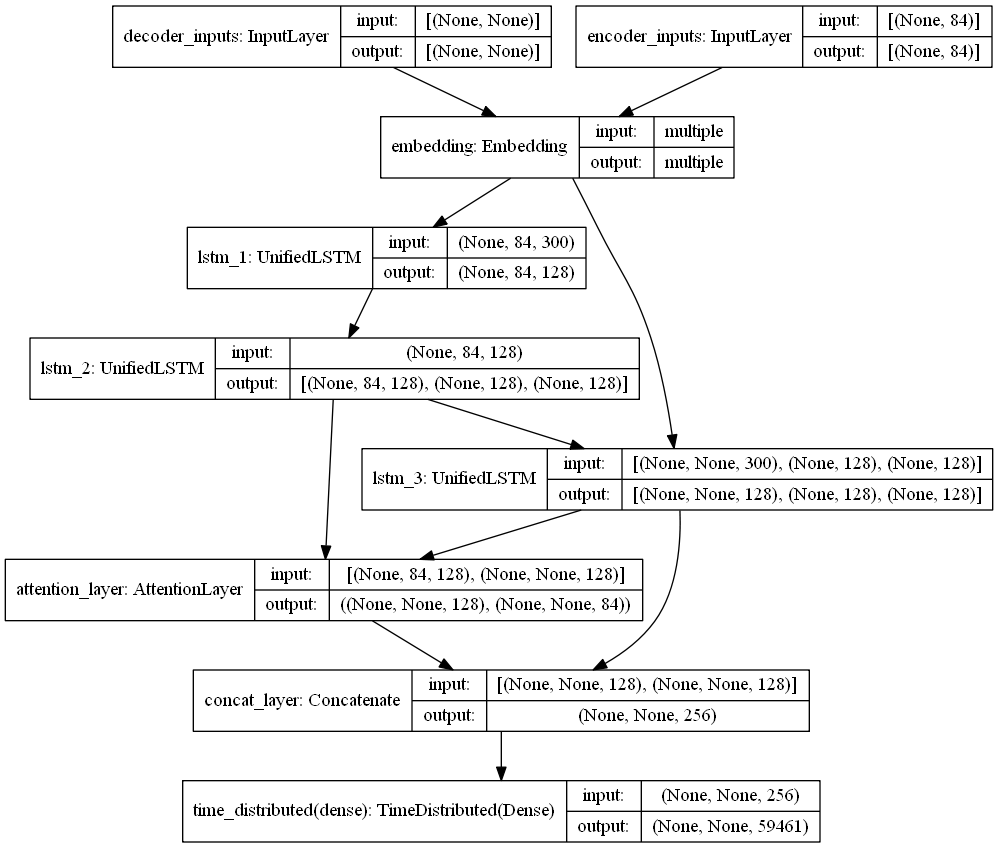

In [27]:
model.summary()
keras.utils.plot_model(model, "./model_img/seq2seq_attn_model.png", show_shapes=True)

In [26]:
# Run training
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [42]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")]
history = model.fit([texts_padded, dec_input], summaries_padded, callbacks=callbacks, validation_split=0.2,
          batch_size=batch_size, epochs=epochs)

Train on 454729 samples, validate on 113683 samples
Epoch 1/50
454729/454729 [==============================] - 13461s 30ms/sample - loss: 3.8231 - val_loss: 3.5314
Epoch 2/50
454729/454729 [==============================] - 13010s 29ms/sample - loss: 3.4752 - val_loss: 3.3584
Epoch 3/50
454729/454729 [==============================] - 12992s 29ms/sample - loss: 3.3553 - val_loss: 3.2808
Epoch 4/50
454729/454729 [==============================] - 12978s 29ms/sample - loss: 3.2917 - val_loss: 3.2379
Epoch 5/50
454729/454729 [==============================] - 12781s 28ms/sample - loss: 3.2578 - val_loss: 3.2151
Epoch 6/50
454729/454729 [==============================] - 12143s 27ms/sample - loss: 3.2522 - val_loss: 3.2270
Epoch 7/50
454729/454729 [==============================] - 12371s 27ms/sample - loss: 3.2458 - val_loss: 3.2048
Epoch 8/50
454729/454729 [==============================] - 11854s 26ms/sample - loss: 3.2225 - val_loss: 3.1873
Epoch 9/50
454729/454729 [==================

In [43]:
# Save model
model.save('./model_file/seq2seq_attn.h5')

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             17838300    encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_1 (UnifiedLSTM)            (None, 84, 128)      219648      embedding[0][0]              

In [18]:
from attention import AttentionLayer
from tensorflow.keras.utils import CustomObjectScope
with CustomObjectScope({'AttentionLayer': AttentionLayer}):
    model = tf.keras.models.load_model('./model_file/seq2seq_attn.h5')
model.summary()

W0929 12:09:33.144211  2644 deprecation.py:506] From c:\users\houlai\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\keras\backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     [(None, 84)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             17838300    encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_1 (UnifiedLSTM)            (None, 84, 128)      219648      embedding[0][0]            

In [21]:
model.save_weights('./model_file/seq2seq_attn_weights.ckpt')

In [16]:
model.load_weights('./model_file/seq2seq_attn_weights.ckpt')

In [17]:
model.predict([texts_padded[0].reshape((1, -1)), dec_input[0].reshape((1, -1))])

array([[[1.6574966e-05, 2.4447054e-02, 1.5731787e-02, ...,
         8.0889713e-06, 8.0616164e-06, 8.0506761e-06],
        [6.1912033e-05, 1.1411990e-02, 1.2263244e-01, ...,
         1.1115979e-05, 1.0740164e-05, 1.0725587e-05],
        [7.9174095e-10, 3.5971228e-04, 4.8970676e-04, ...,
         1.7138782e-05, 1.6605143e-05, 1.6566675e-05],
        [1.6208867e-06, 6.2384168e-03, 9.4246173e-01, ...,
         1.4133080e-08, 1.3884594e-08, 1.3903356e-08],
        [4.2472720e-11, 4.4851441e-02, 9.0337402e-01, ...,
         3.8399912e-18, 3.4405440e-18, 3.4516127e-18]]], dtype=float32)

In [19]:
# tf.reset_default_graph()
# 建立推断模型
# 定义 sampling 模型
# 定义 encoder 模型，得到输出encoder_states
# encoder_inputs = keras.Input(shape=(texts_maxlen,), dtype=tf.int32, name="encoder_inputs")
# Define an input sequence and process it.
# enco_embedding = embedding_layer(encoder_inputs)
# enco_output_1 = en_lstm_1(enco_embedding)
# encoder_outputs, state_h, state_c = en_lstm_2(enco_output_1)
# We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

encoder_model = keras.Model(encoder_inputs, [encoder_outputs] + encoder_states)

# decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
decoder_state_input_h = keras.Input(shape=(rnn_size,))
decoder_state_input_c = keras.Input(shape=(rnn_size,))

decoder_hidden_state_input = keras.Input(shape=(texts_maxlen, rnn_size))

# 得到解码器的输出以及中间状态
# Get the embeddings of the decoder sequence
dec_emb2 = embedding_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = de_lstm(dec_emb2, 
                                               initial_state=[decoder_state_input_h, decoder_state_input_c])
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# concat_layer = model.get_layer("concat_layer")
decoder_inf_concat = concat_layer([decoder_outputs2, attn_out_inf])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)
# Final decoder model
decoder_model = keras.Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [20]:
o, h, c = encoder_model.predict(texts_padded[0].reshape(1, -1))

In [21]:
target_seq = np.zeros((1,1), dtype=np.int32)
target_seq[0, 0] = vocab_to_int.get("<GO>")
decoder_model.predict([target_seq, o, h, c])

InvalidArgumentError: You must feed a value for placeholder tensor 'encoder_inputs' with dtype float and shape [?,84]
	 [[{{node encoder_inputs}}]] [Op:__inference_keras_scratch_graph_4130]

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_encoder_inputs (InputLaye [(None, 84)]              0         
_________________________________________________________________
embedding (Embedding)        multiple                  17838300  
_________________________________________________________________
lstm_1 (UnifiedLSTM)         (None, 84, 128)           219648    
_________________________________________________________________
lstm_2 (UnifiedLSTM)         [(None, 84, 128), (None,  131584    
Total params: 18,189,532
Trainable params: 18,189,532
Non-trainable params: 0
_________________________________________________________________


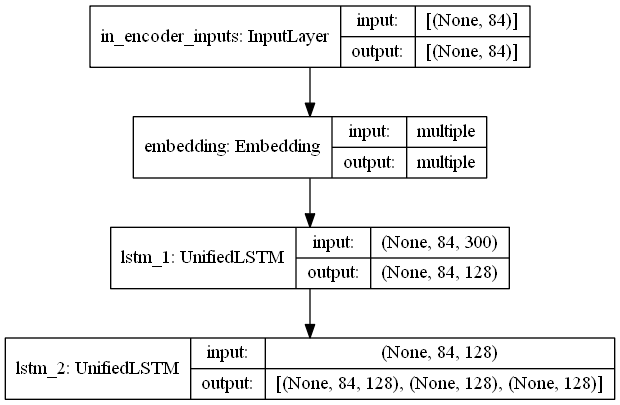

In [37]:
encoder_model.summary()
keras.utils.plot_model(encoder_model, "./model_img/encoder_model.png", show_shapes=True)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_decoder_inputs (InputLayer)  [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             17838300    in_decoder_inputs[0][0]          
__________________________________________________________________________________________________
decoder_init_state_h (InputLaye [(None, 128)]        0                                            
__________________________________________________________________________________________________
decoder_init_state_c (InputLaye [(None, 128)]        0                                            
____________________________________________________________________________________________

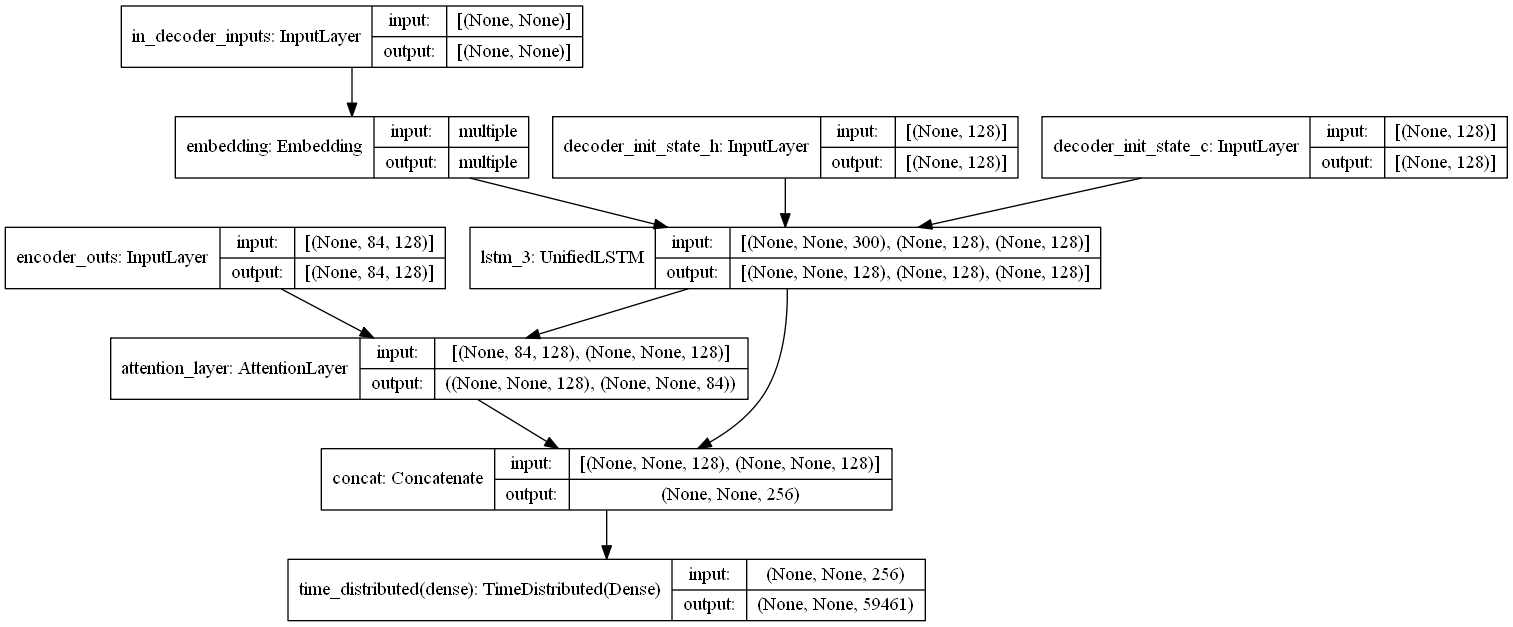

In [38]:
decoder_model.summary()
keras.utils.plot_model(decoder_model, "./model_img/decoder_model.png", show_shapes=True)

In [36]:
def decode_sequence(input_seq):
    # 将输入序列进行编码
    print(input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print(e_out)
    print(e_out.shape)
    print(e_h.shape)
    print(e_c.shape)

    # 生成一个size=1的空序列
    # 将这个空序列的内容设置为开始字符
    target_seq = np.zeros((1,1), dtype=np.int32)
    target_seq[0, 0] = vocab_to_int.get("<GO>")
    print(target_seq)
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = int_to_vocab[sampled_token_index]
        
        if(sampled_token!='<EOS>'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<EOS>'  or len(decoded_sentence.split()) >= (summaries_maxlen-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
for seq_index in [0, 100, 1000, 10000]:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = texts_padded[seq_index].reshape(1, texts_maxlen)
#     print(input_seq)
    decoded_sentence = decode_sequence(input_seq)
    input_text = [int_to_vocab[i] for i in input_seq[0] if i != vocab_to_int["<PAD>"]]
    
    print("\n*******************我是分隔符,当前index{}********************".format(seq_index))
    print('Input int sentence:', [i for i in texts_padded[seq_index] if i != vocab_to_int["<PAD>"]])
    print('Input text sentence:', " ".join(input_text))
    print('Decoded sentence:', decoded_sentence)

(1, 84)
[[[-3.27233970e-01  2.32343540e-01 -2.55297810e-01 ...  3.66054386e-01
   -4.73526716e-01  2.42950208e-02]
  [ 3.36234182e-01  8.73756349e-01 -2.42739409e-01 ...  8.00196886e-01
   -7.47149348e-01  1.02484785e-01]
  [ 2.82621324e-01  9.81799245e-01 -8.01578090e-02 ...  8.32532585e-01
   -7.58344293e-01  1.40708173e-02]
  ...
  [-9.99888301e-01  5.25932875e-04  9.91714239e-01 ... -9.61303592e-01
    1.91032887e-05 -1.12268269e-01]
  [-9.99884546e-01  5.29161480e-04  9.91926074e-01 ... -9.59732831e-01
    1.81794167e-05 -1.12531438e-01]
  [-9.99880791e-01  5.32366626e-04  9.92141366e-01 ... -9.58126545e-01
    1.73747540e-05 -1.12794019e-01]]]
(1, 84, 128)
(1, 128)
(1, 128)
[[3.]]


InvalidArgumentError: You must feed a value for placeholder tensor 'encoder_inputs' with dtype float and shape [?,84]
	 [[{{node encoder_inputs}}]] [Op:__inference_keras_scratch_graph_3592]

In [55]:
word_embedding_matrix[:2,:5]

array([[ 0.2261,  0.0492, -0.028 ,  0.0038, -0.0678],
       [ 0.0895,  0.095 , -0.0286, -0.0481,  0.0414]])

In [11]:
int_to_vocab[0]

'ww2'